In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Preview the datasets
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [2]:
# Merge customers with transactions
data = transactions.merge(customers, on='CustomerID')

# Calculate aggregated features
customer_aggregates = data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # Total spending, average transaction value, number of transactions
    'ProductID': 'nunique'                  # Number of unique products purchased
}).reset_index()

# Rename columns for clarity
customer_aggregates.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'TransactionCount', 'UniqueProducts']

# Merge aggregated features with customer profile
clustering_data = customers.merge(customer_aggregates, on='CustomerID', how='left')

# Fill missing values with 0
clustering_data.fillna(0, inplace=True)

print(clustering_data.head())


  CustomerID        CustomerName         Region  SignupDate  TotalSpending  \
0      C0001    Lawrence Carroll  South America  2022-07-10        3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13        1862.74   
2      C0003      Michael Rivera  South America  2024-03-07        2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09        5354.88   
4      C0005         Laura Weber           Asia  2022-08-15        2034.24   

   AvgTransactionValue  TransactionCount  UniqueProducts  
0              670.904               5.0             5.0  
1              465.685               4.0             4.0  
2              681.345               4.0             4.0  
3              669.360               8.0             8.0  
4              678.080               3.0             3.0  


In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Region' column
encoder = LabelEncoder()
clustering_data['Region'] = encoder.fit_transform(clustering_data['Region'])


In [4]:
features = clustering_data[['Region', 'TotalSpending', 'AvgTransactionValue', 'TransactionCount', 'UniqueProducts']]


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

print(normalized_features[:5])


[[1.         0.31427402 0.50705699 0.45454545 0.5       ]
 [0.         0.17451402 0.35195622 0.36363636 0.4       ]
 [1.         0.25533195 0.5149481  0.36363636 0.4       ]
 [1.         0.50168121 0.50589006 0.72727273 0.8       ]
 [0.         0.1905813  0.51248048 0.27272727 0.3       ]]


In [6]:
from sklearn.cluster import KMeans

# Define the number of clusters
k = 5  # You can try values between 2 and 10
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model
clustering_data['Cluster'] = kmeans.fit_predict(normalized_features)


In [7]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index
db_index = davies_bouldin_score(normalized_features, clustering_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.4185396995469082


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

# Add PCA results to DataFrame
clustering_data['PCA1'] = pca_features[:, 0]
clustering_data['PCA2'] = pca_features[:, 1]


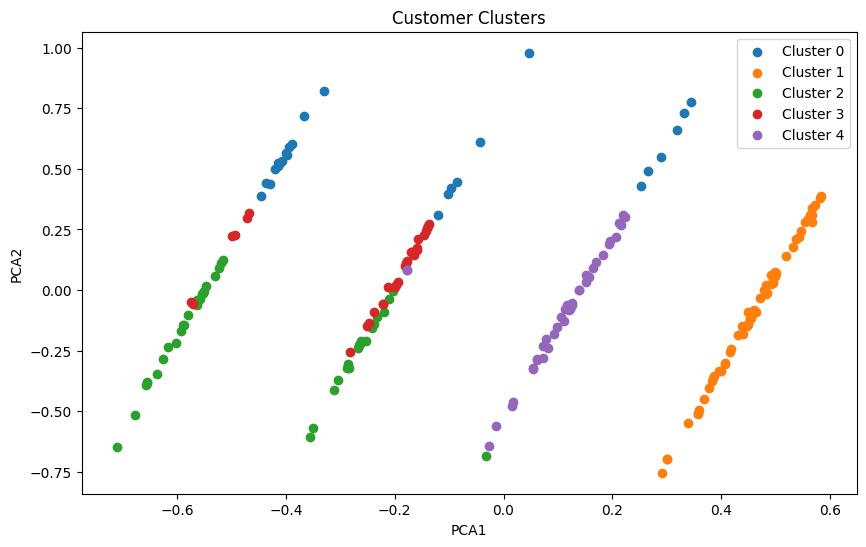

In [9]:
# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(k):
    cluster_data = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [10]:
# Save clustering results
clustering_data.to_csv('Customer_Clusters.csv', index=False)
